In [15]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
global DATA_DIR
DATA_DIR = f'{ROOT_DIR}/data/CIFAR'

In [16]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pickle
import random
import sys
sys.path.append(f'{ROOT_DIR}/code/CIFAR')
import embedding as embed
sys.path.append(f'{ROOT_DIR}/code/helper')
import OTCost as ot
import importlib
importlib.reload(ot)
importlib.reload(embed)
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
import torch

Files already downloaded and verified
Files already downloaded and verified


# Embed Images

In [6]:
n_emb = 1000
BATCH_SIZE = 64

## Download data

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR100(root=f'{DATA_DIR}/', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR100(root=f'{DATA_DIR}/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Load Data

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load autoencoder model

In [ ]:
with open(f'{ROOT_DIR}/data/CIFAR/losses_2.json', 'r') as f:
        losses = json.load(f)

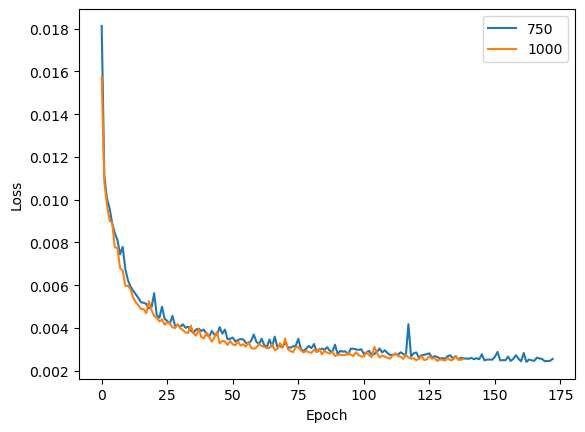

In [78]:
#Plot validation losses (100 and 500 were checkpointed)
for key, value in losses.items():
    label = key
    loss_list = value[2]
    plt.plot(loss_list, label=label)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model = embed.Autoencoder(n_emb)
if f'model_checkpoint_{n_emb}.pth' in os.listdir(f'{DATA_DIR}/'):
    state_dict = torch.load(f'{DATA_DIR}/model_checkpoint_{n_emb}.pth', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()

## Visualise

In [13]:
images, _ = next(iter(train_loader))
with torch.no_grad():
    reconstructed_images = model(images)
images = images.numpy()
reconstructed_images = reconstructed_images.numpy()

In [9]:
def visualize(images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


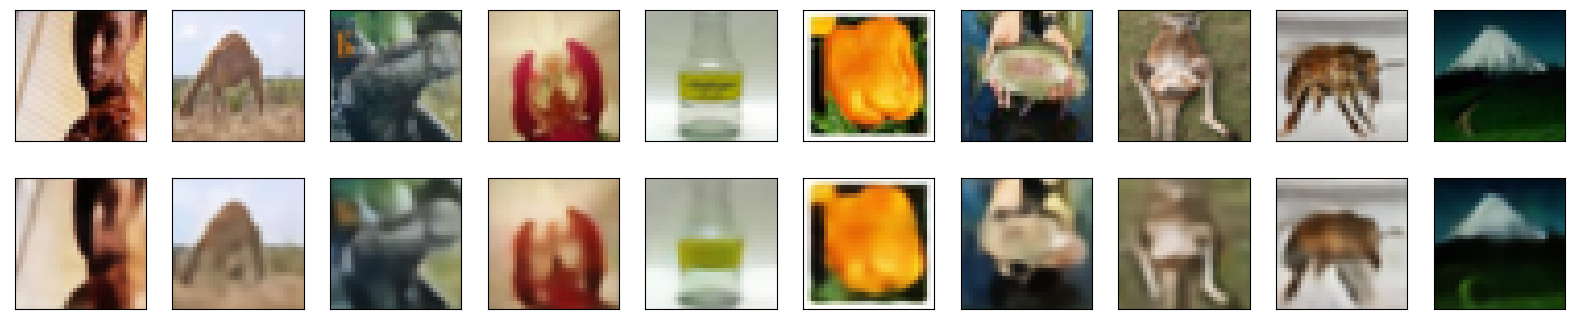

In [14]:
visualize(images, reconstructed_images)

# Create datasets

## Load label mapping

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        dict_decoded = {}
    for key in dict:
        dict_decoded[key.decode('utf-8')] = dict[key]
    return dict_decoded

In [ ]:
data_dict = unpickle(f'{DATA_DIR}/cifar-100-python/train')
fine_to_coarse = {}
for i, fine_label in enumerate(data_dict['fine_labels']):
    coarse_label = data_dict['coarse_labels'][i]
    fine_to_coarse[fine_label] = coarse_label

## Embed all datapoints

In [ ]:
data = []
for images, lbls in train_loader:
    with torch.no_grad():
        embedded_images = model(images, get_embedding=True)
    embeddings_numpy = embedded_images.numpy()
    labels_numpy = lbls.numpy()
    images_numpy = images.numpy()
    for img, emb, label in zip(images_numpy, embeddings_numpy, labels_numpy):
        coarse_label = fine_to_coarse[label]
        data.append((img, emb, label, coarse_label))

In [18]:
with open(f'{DATA_DIR}/cifar_{n_emb}_emb.pkl', 'wb') as f:
    pickle.dump(data, f)

## Data loader

In [7]:
class EmbeddedImagesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, embedding, label, coarse_label = self.data[idx]
        return image, embedding, label, coarse_label

In [9]:
with open(f'{DATA_DIR}/cifar_{n_emb}_emb.pkl', 'rb') as f:
    data= pickle.load(f)

## Extract data

In [8]:
def extract_by_labels(dataset, target_labels, label_type = 'fine'):
    extracted_data = []
    for image, embedding, fine_label, coarse_label in dataset:
        if label_type == 'fine':
            label = fine_label
        else:
            label = coarse_label
        if label in target_labels:
            extracted_data.append((image, embedding, fine_label, coarse_label))
    return EmbeddedImagesDataset(extracted_data)

In [11]:
def get_datasets(dataset, labels_extract, label_type = 'fine'):
    d1 = extract_by_labels(dataset, labels_extract[0], label_type)
    d2 = extract_by_labels(dataset, labels_extract[1], label_type)
    return d1, d2

In [12]:
def sampler(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    sampled_data = [dataset[i] for i in indices]
    embs = np.array([entry[1] for entry in sampled_data])
    label = np.array([entry[2] for entry in sampled_data])
    return embs, label


In [13]:
def saveDataset(dataset, name):
    images = np.array([entry[0] for entry in dataset])
    label = np.array([entry[2] for entry in dataset])
    np.savez(f'{DATA_DIR}/{name}.npz', data = images, labels = label)
    return

## Datasets

In [106]:
num_samples = 2000
DATASET = 'CIFAR'
SAVE = True

In [107]:
#same images
importlib.reload(ot)
labels_extract = [[x for x in range(10)], [x for x in range(10)]]
d1, d2 = get_datasets(data, labels_extract)
x1, y1 =  sampler(d1, num_samples)
x2, y2 =  sampler(d2, num_samples)
data_ = {'1': x1, '2': x2}
label_ = {'1': y1, '2': y2}

CIFAR_OTCost_label = ot.OTCost(DATASET, data_, label_)
cost = CIFAR_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

if SAVE:
    saveDataset(d1, f'data_1_{cost}')
    saveDataset(d2, f'data_2_{cost}')

cost: 0.08


In [108]:
#near identical images where last 3 are in the same coarse label group (boy, woman, dinosaur, fish, shark, mountain, large carnivore, fruit&veg)
importlib.reload(ot)
labels_extract = [[11,98,29,73, 78, 49, 97, 51, 55, 92], [11,98,29,73, 78, 49, 42, 83, 72, 82]]
d1, d2 = get_datasets(data, labels_extract)
x1, y1 =  sampler(d1, num_samples)
x2, y2 =  sampler(d2, num_samples)
data_ = {'1': x1, '2': x2}
label_ = {'1': y1, '2': y2}

CIFAR_OTCost_label = ot.OTCost(DATASET, data_, label_)
cost = CIFAR_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

if SAVE:
    saveDataset(d1, f'data_1_{cost}')
    saveDataset(d2, f'data_2_{cost}')

cost: 0.21


In [21]:
#overlapping coarse label (human, small mammal, reptile, fish, flower, mountain, large carnivore, fruit&veg)
importlib.reload(ot)
labels_extract = [[11,50,78,1,92, 78, 49, 97, 55, 16, 14], [11, 36, 29, 73, 82, 78, 49, 42, 12, 23, 51]]
d1, d2 = get_datasets(data, labels_extract)
x1, y1 =  sampler(d1, num_samples)
x2, y2 =  sampler(d2, num_samples)
data_ = {'1': x1, '2': x2}
label_ = {'1': y1, '2': y2}

CIFAR_OTCost_label = ot.OTCost(DATASET, data_, label_)
cost = CIFAR_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

if SAVE:
    saveDataset(d1, f'data_1_{cost}')
    saveDataset(d2, f'data_2_{cost}')

cost: 0.30


In [147]:
importlib.reload(ot)
labels_extract = [[11,50,78,8,92,2,49,98,89,3], [17, 36, 30, 73, 83,28, 34, 42, 10, 20]]
d1, d2 = get_datasets(data, labels_extract)
x1, y1 =  sampler(d1, num_samples)
x2, y2 =  sampler(d2, num_samples)
data_ = {'1': x1, '2': x2}
label_ = {'1': y1, '2': y2}

CIFAR_OTCost_label = ot.OTCost(DATASET, data_, label_)
cost = CIFAR_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

if SAVE:
    saveDataset(d1, f'data_1_{cost}')
    saveDataset(d2, f'data_2_{cost}')

cost: 0.38


## Save classes used

In [145]:
classes_used = {}

labels_extract = [[x for x in range(10)], [x for x in range(10)]]
classes_used[0.08] = labels_extract

labels_extract = [[11,98,29,73, 78, 49, 97, 51, 55, 92], [11,98,29,73, 78, 49, 42, 83, 72, 82]]
classes_used[0.21]= labels_extract

labels_extract = [[11,50,78,1,92, 78, 49, 97, 55, 16, 14], [11, 36, 29, 73, 82, 78, 49, 42, 12, 23, 51]]
classes_used[0.30]  =  labels_extract


labels_extract = [[11,50,78,8,92,2,49,98,89,3], [17, 36, 30, 73, 83,28, 34, 42, 10, 20]]
classes_used[0.38] =  labels_extract


In [146]:
with open(f'{DATA_DIR}/CLASSES', 'wb') as f:
    pickle.dump(classes_used, f)